<font size="5">
 <div class="alert alert-block alert-info"><b>Master in Data Science - ISCTE <b>
     </div>
</font>   
    
<font size="5"> OEOD </font>

<font size="3"> Afonso Fareleiro - Armando Ferreira - Tomás Carvalho </font>
  
<font size="3"> Group 12 - 'MU' Micron Technology, Inc 

# RL for algorithmic trading

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import gymnasium as gym
import quantstats as qs
import itertools
from tqdm import tqdm

# High-quality figures
%config InlineBackend.figure_format = 'svg'

## 1. Obtain/Extract the historical stock prices

In [2]:
# Historical stock price data for MU, from the period 2019 to 2023
## 'MU - Micron Technology, Inc' is an US based semiconductor company

mu = yf.Ticker("MU")
mu_data = mu.history(start="2019-01-01", end="2023-09-30")

mu_data.info()
mu_data.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1195 entries, 2019-01-02 00:00:00-05:00 to 2023-09-29 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1195 non-null   float64
 1   High          1195 non-null   float64
 2   Low           1195 non-null   float64
 3   Close         1195 non-null   float64
 4   Volume        1195 non-null   int64  
 5   Dividends     1195 non-null   float64
 6   Stock Splits  1195 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 74.7 KB


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-09-25 00:00:00-04:00,68.176264,69.074767,67.497396,68.465782,14900000,0.0,0.0
2023-09-26 00:00:00-04:00,67.856800,68.935003,67.477428,67.826851,12752500,0.0,0.0
2023-09-27 00:00:00-04:00,68.006551,68.735331,66.638830,68.096397,20852300,0.0,0.0
2023-09-28 00:00:00-04:00,65.860130,66.978259,63.723694,65.091408,46749800,0.0,0.0
2023-09-29 00:00:00-04:00,66.249478,68.615533,66.249478,67.916695,24307500,0.0,0.0


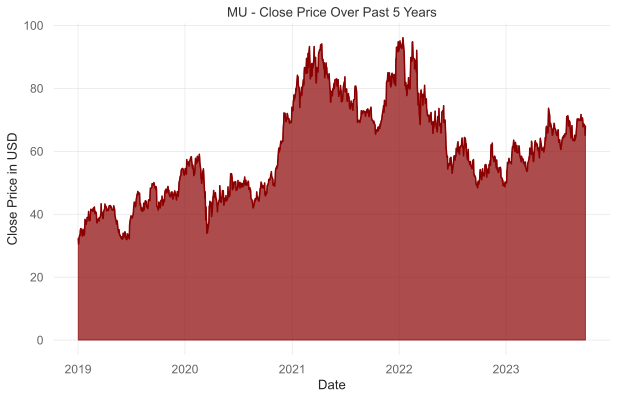

In [3]:
# Daily close price data for MU
plt.fill_between(mu_data.index, mu_data['Close'], color='darkred', alpha=0.7)
plt.plot(mu_data.index, mu_data['Close'], color='darkred', label='Close Price Line')
plt.xlabel('Date')
plt.ylabel('Close Price in USD')
plt.title('MU - Close Price Over Past 5 Years')
plt.grid(True)
plt.show()

## 2. Calculate returns, expected mean returns and risk

In [24]:
# Asset Returns/Rate of Returns: the cumulative daily rate of return is useful to determine /
#                                   the value of an investment at regular intervals.
data_close = mu_data[['Close']]
data_close.columns = ['MU']

returns = np.log(data_close / data_close.shift(1))
returns = returns.dropna()

# Expected Mean Returns
mean_returns = returns.mean()

# Volatility: market volatility is defined as the standard deviation of prices/returns.
vol = returns.std()

# Gain-Loss Ratio (GLR) represents the relative relationship of trades with a positive /
#                                       return and trades with a negative return
glr = returns[returns['MU'] > 0].sum() / returns[returns['MU'] < 0].sum().abs()

# Sharpe Ratio (SR) is the amount of excess return over the risk-free rate as the relevant measure of risk.
## rf is daily risk free rate.
rf = (1.02 ** (1 / 360)) - 1
sr = (mean_returns - rf) / vol

# Compound Annual Growth Rate (CAGR)
cumulative_returns = returns.cumsum()
num_trading_days = len(returns)
cagr = (cumulative_returns['MU'][-1]) ** (252/num_trading_days) - 1

# Variance
var = returns.var() * 252

# CVAR
cvar = returns[returns <= np.percentile(returns, 5)].mean() * 252

# See metrics in table format
data_summary = pd.DataFrame({
    'Mean Returns': mean_returns,
    'Volatility': vol,
    'Gain-Loss Ratio (GLR)': glr,
    'Sharpe Ratio (SR)': sr,
    'CAGR': cagr,
    'Variance': var,
    'CVAR': cvar
})

data_summary


C:\Users\Admin\AppData\Local\Temp\ipykernel_20392\3451601222.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr = (cumulative_returns['MU'][-1]) ** (252/num_trading_days) - 1


,Mean Returns,Volatility,Gain-Loss Ratio (GLR),Sharpe Ratio (SR),CAGR,Variance,CVAR
MU,0.000624,0.029188,1.059818,0.019496,-0.060209,0.214685,-16.058256


## 3. Define statistical trading strategy based on Exponetenial Moving Averages

In [5]:
# Exponential moving average (EMA) strategy
def ema_strategy(data, small, large):
    signals = pd.DataFrame(data)

    # EMA for 20 and 100-day windows
    signals['ema_short'] = signals['Close'].ewm(span = small, adjust = False).mean()
    signals['ema_long'] = signals['Close'].ewm(span = large, adjust = False).mean()
                         
    # Define a crossover strategy
    signals['bullish'] = 0.0
    signals['bullish'] = np.where(signals['ema_short'] > signals['ema_long'], 1, 0)
    signals['crossover'] = signals['bullish'].diff()

    # Calculate passive and strategy's returns
    signals['returns'] = np.log(signals['Close'] / signals['Close'].shift(1))
    signals['strategy'] = signals['bullish'].shift(1) * signals['returns']
    
    return signals

C:\Users\Admin\AppData\Local\Temp\ipykernel_20392\3536721409.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(ema_strat['ema_long'][idx], 'ro', markersize = 3, color='#000000')
C:\Users\Admin\AppData\Local\Temp\ipykernel_20392\3536721409.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(ema_strat['ema_long'][idx], 'ro', markersize = 3, color='#000000')


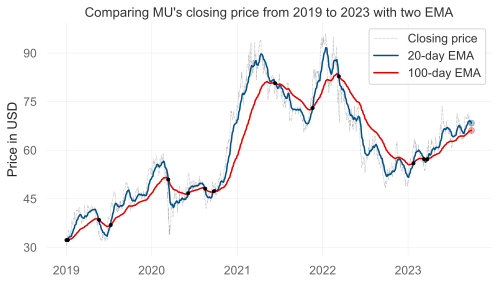

In [6]:
# Initiate strategy
ema_strat = ema_strategy(mu_data, 20, 100)

# Plot exponential moving averages for our strategy
# fig, ax = plt.subplots(figsize=(13.33,7.5), dpi = 96)
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(ema_strat['Close'], label='Closing price', color='grey', linestyle=':', linewidth=0.5)
ax.plot(ema_strat['ema_short'], label='20-day EMA', color='#014f86')
ax.plot(ema_strat.index[-1], ema_strat['ema_short'].iloc[-1], 'o', markersize=6, alpha=0.3, color='#014f86')
ax.plot(ema_strat['ema_long'], label='100-day EMA', color='#DC0000')
ax.plot(ema_strat.index[-1], ema_strat['ema_long'].iloc[-1], 'o', markersize=6, alpha=0.3, color='#DC0000')

# Plot crossovers
idx = np.argwhere(ema_strat['crossover']).flatten()
ax.plot(ema_strat['ema_long'][idx], 'ro', markersize = 3, color='#000000')

# Add Legend and Labels
ax.legend(loc='best')

# Prettify

## Create the grid 
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

## Reformat y-axis
ax.set_ylabel('Price in USD')
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

## Remove the spines
ax.spines[['top','right','bottom']].set_visible(False)

## Make the left spine thicker
ax.spines['left'].set_linewidth(1.1)
# Add in title and subtitle
ax.set_title(label="Comparing MU's closing price from 2019 to 2023 with two EMA")
## Adjust the margins around the plot area
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)

# Show the plot
plt.show()

<Axes: title={'center': 'Gross performance of MU compared to the EMA-based strategy'}, xlabel='Date'>

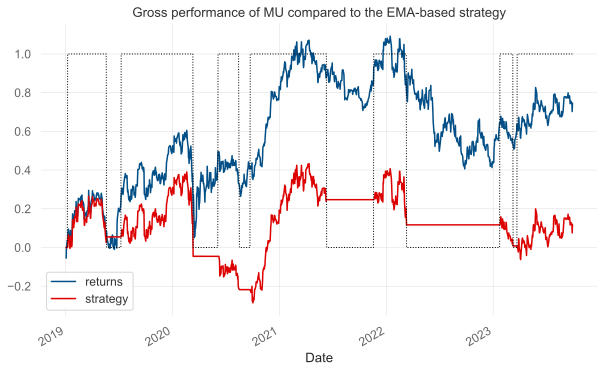

In [31]:
# Plot our strategy's returns compared to MU's stock performance
ema_strat[['returns', 'strategy']].cumsum().plot(figsize=(10, 6), 
                                                 title="Gross performance of MU compared to the EMA-based strategy",
                                                 color=['#014f86', '#DC0000'])

ema_strat['bullish'].plot(color='black', linestyle=':', linewidth=1)


## 4. Evaluate the efficacy of the trading strategy

In [62]:
qs.reports.metrics(ema_strat['strategy'])

# Calculate Annualized Volatility
from math import sqrt
vol = ema_strat['strategy'].std() * sqrt(252)
vol

                    Strategy
------------------  ----------
Start Period        2019-01-03
End Period          2023-09-29
Risk-Free Rate      0.0%
Time in Market      61.0%

Cumulative Return   -14.63%
CAGR﹪              -2.28%

Sharpe              0.07
Prob. Sharpe Ratio  56.32%
Sortino             0.1
Sortino/√2          0.07
Omega               1.02

Max Drawdown        -51.57%
Longest DD Days     1318

Gain/Pain Ratio     0.02
Gain/Pain (1M)      0.08

Payoff Ratio        0.98
Profit Factor       1.02
Common Sense Ratio  1.01
CPC Index           0.51
Tail Ratio          0.99
Outlier Win Ratio   6.5
Outlier Loss Ratio  2.64

MTD                 -3.04%
3M                  0.22%
6M                  11.14%
YTD                 -4.11%
1Y                  -4.11%
3Y (ann.)           4.68%
5Y (ann.)           -2.28%
10Y (ann.)          -2.28%
All-time (ann.)     -2.28%

Avg. Drawdown       -12.18%
Avg. Drawdown Days  170
Recovery Factor     0.23
Ulcer Index         0.29
Serenity Index      

0.34075366453736267

0.34075366453736267

## 5. Training a Deep Q-learning model in stock trading

In [37]:
# Import libraries for environment and model
from gym_anytrading.envs import StocksEnv, Actions, Positions
from stable_baselines3 import DQN

In [36]:
# Create a gym_anytrading environment using MU's stock data
env = gym.make('stocks-v0',
    df = pd.DataFrame(mu_data['Close']),
    window_size = 10,
    frame_bound = (10, len(mu_data)),
)

In [ ]:

# Create a DQN model and set parameters
model = DQN("MlpPolicy",
            env = env,
            buffer_size = 20000, # number of old observation steps saved
            learning_starts = 1000, # memory warmup 
            train_freq = 1, # prediction network gets an update each train_freq's step
            batch_size = 4, # mini batch size drawn at each update step
            policy_kwargs = {'net_arch': [50]}, # hidden layers architecture of MLP
            exploration_fraction = 0.2, # fraction of training steps the epsilon decays 
            gamma = 0.95, # discount factor
            learning_rate = 0.0001, # learning rate
            verbose = 0, # verbosity of stable-basline's prints
            target_update_interval = 100, # target network gets updated each target_update_interval's step
            tau = 1e-4,
            seed = 2023
            )

simulation_time = 5
tau = 1e-4
nb_steps = int(simulation_time // tau)

# Initiate learning
#model.learn(total_timesteps= nb_steps, log_interval=4)

# Save learned model as a zip file
# model.save("dqn_mu")

# Load saved model (zip file)
model = DQN.load("dqn_mu")

In [76]:
# Reset environment to its initial state
observation, info = env.reset(seed=2023)

# Initiate dictionary to store action counts
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

# Loop to apply the trained model on the environment
while True:
    action, _states = model.predict(observation, deterministic = True)
    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        print("info:", info)
        print("action_stats:", action_stats)
        break

env.close()

info: {'total_reward': 32.78544616699219, 'total_profit': 1.0759319946915764, 'position': <Positions.Long: 1>}
action_stats: {<Actions.Sell: 0>: 40, <Actions.Buy: 1>: 1144}


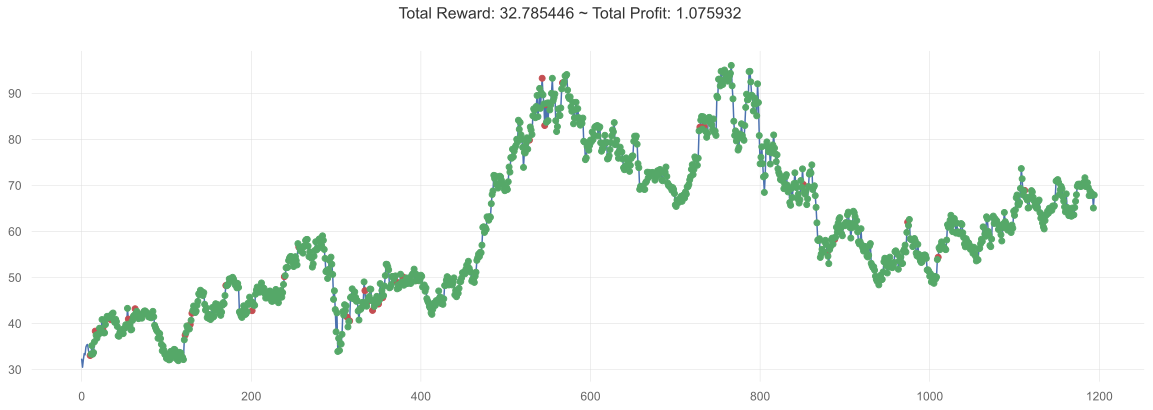

In [77]:
# Plot results
plt.figure(figsize=(20, 6))
env.unwrapped.render_all()
plt.show()

## 6. Evaluate the efficacy of the RL strategy

In [61]:
# Calculate metrics and visualize plots for the DeepQ-Learning strategy
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=mu_data.index[0:1184])
rl_returns = net_worth.pct_change().iloc[1:]

rl_returns = rl_returns.tz_localize(None)

qs.reports.metrics(rl_returns, )

                    Strategy
------------------  ----------
Start Period        2019-01-03
End Period          2023-09-14
Risk-Free Rate      0.0%
Time in Market      4.0%

Cumulative Return   7.59%
CAGR﹪              1.08%

Sharpe              0.22
Prob. Sharpe Ratio  68.21%
Sortino             0.32
Sortino/√2          0.22
Omega               1.22

Max Drawdown        -46.87%
Longest DD Days     940

Gain/Pain Ratio     0.22
Gain/Pain (1M)      0.3

Payoff Ratio        1.0
Profit Factor       1.22
Common Sense Ratio  -
CPC Index           0.67
Tail Ratio          -
Outlier Win Ratio   32.01
Outlier Loss Ratio  0.32

MTD                 -0.93%
3M                  -0.93%
6M                  19.14%
YTD                 19.14%
1Y                  8.32%
3Y (ann.)           2.44%
5Y (ann.)           1.08%
10Y (ann.)          1.08%
All-time (ann.)     1.08%

Avg. Drawdown       -23.94%
Avg. Drawdown Days  298
Recovery Factor     0.74
Ulcer Index         0.25
Serenity Index      0.06


## 7. Fine-tune your algorithms

### 7.1. Optimizing the Exponential Moving Averages parameters

In [67]:
# Optimizing EMA strategy
import ema
ema_opt = ema.EMA('MU', 40, 20, "2019-01-01", "2023-09-30")

ema_opt.optimize_parameters((10, 100, 2), (100, 400, 2))

(array([ 88., 292.]), 2.31)

                    Strategy
------------------  ----------
Start Period        2019-01-03
End Period          2023-09-29
Risk-Free Rate      0.0%
Time in Market      78.0%

Cumulative Return   53.6%
CAGR﹪              6.45%

Sharpe              0.43
Prob. Sharpe Ratio  82.26%
Sortino             0.61
Sortino/√2          0.43
Omega               1.09

Max Drawdown        -46.06%
Longest DD Days     942

Gain/Pain Ratio     0.09
Gain/Pain (1M)      0.58

Payoff Ratio        0.96
Profit Factor       1.09
Common Sense Ratio  1.12
CPC Index           0.56
Tail Ratio          1.03
Outlier Win Ratio   5.53
Outlier Loss Ratio  2.83

MTD                 -3.04%
3M                  0.22%
6M                  2.77%
YTD                 2.77%
1Y                  2.77%
3Y (ann.)           7.08%
5Y (ann.)           6.45%
10Y (ann.)          6.45%
All-time (ann.)     6.45%

Avg. Drawdown       -8.46%
Avg. Drawdown Days  61
Recovery Factor     1.82
Ulcer Index         0.23
Serenity Index      0.25


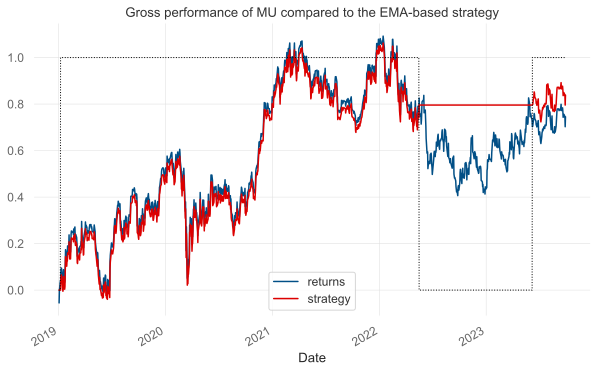

In [66]:
# Plot our optimized strategy's returns compared to MU's stock performance
ema_optz = ema_strategy(mu_data, 88, 292)
ema_optz[['returns', 'strategy']].cumsum().plot(figsize=(10, 6), 
                                                 title="Gross performance of MU compared to the EMA-based strategy",
                                                 color=['#014f86', '#DC0000'])

ema_optz['bullish'].plot(color='black', linestyle=':', linewidth=1)

ema_optz = ema_optz['strategy'].tz_localize(None)
qs.reports.metrics(ema_optz)

### 7.2. Hyperparameter tuning for RL strategy

In [20]:
# Define hyperparameters ranges
buffer_sizes = [5000, 20000]
learning_start_values = [200, 1000]
train_freq_values = [1, 4]
batch_sizes = [4, 32]
policy_kwargs_options = [{'net_arch': [50]}, {'net_arch': [50, 100]}]
exploration_fractions = [0.05, 0.2]
gammas = [0.8, 0.95]
learning_rates = [0.1, 0.0001]

# Generate all combinations
all_combinations = list(itertools.product(
    buffer_sizes,
    learning_start_values,
    train_freq_values,
    batch_sizes,
    policy_kwargs_options,
    exploration_fractions,
    gammas,
    learning_rates 
))

simulation_time = 5
tau = 1e-4
nb_steps = int(simulation_time // tau)

In [21]:
# Define the total number of combinations for the progress bar
total_combinations = len(all_combinations)
total_combinations

256

In [22]:
# Define evaluation functions that return performance metrics for the model
def get_profit(model):
    # Reset environment to its initial state
    observation, info = env.reset(seed=2023)

    # Initiate dictionary to store action counts
    action_stats = {Actions.Sell: 0, Actions.Buy: 0}

    # Loop to apply the trained model on the environment
    while True:
        action, _states = model.predict(observation, deterministic = True)
        action_stats[Actions(action)] += 1
        observation, reward, terminated, truncated, info = env.step(action)

        if terminated or truncated:
           return info["total_profit"]

def get_reward(model):
    # Reset environment to its initial state
    observation, info = env.reset(seed=2023)

    # Initiate dictionary to store action counts
    action_stats = {Actions.Sell: 0, Actions.Buy: 0}

    # Loop to apply the trained model on the environment
    while True:
        action, _states = model.predict(observation, deterministic = True)
        action_stats[Actions(action)] += 1
        observation, reward, terminated, truncated, info = env.step(action)

        if terminated or truncated:
           return info["total_reward"]

In [ ]:
# Create a progress bar
progress_bar = tqdm(total=total_combinations, desc='Grid Search Progress', position=0, leave=True)

# Create dataframe to store results
results = pd.DataFrame(columns=["Parameters", "Total Reward", "Total Profit"])

# Grid Search
""" for combination in all_combinations:
    (buffer_size, learning_starts, train_freq, batch_size, policy_kwargs, exploration_fraction, gamma, learning_rate) = combination

    # Define the model
    model = DQN("MlpPolicy", env, buffer_size=buffer_size, learning_starts=learning_starts,
                train_freq=train_freq, batch_size=batch_size, gamma=gamma, policy_kwargs=policy_kwargs,
                exploration_fraction=exploration_fraction, learning_rate=learning_rate, target_update_interval=100,
                tau = 1e-4, verbose=0, seed = 2023)

    # Train the model
    model.learn(total_timesteps=nb_steps)

    # Evaluate the model
    reward = get_reward(model)
    profit = get_profit(model)
    
    if profit > 1.5:
        # Clean combination of parameters
        combination_strings = [str(item).replace('{', '').replace('}', '').replace('[', '').replace(']', '').replace(':', '').replace("'", '').replace(" ", "") for item in combination]
        result_string = '_'.join(combination_strings)
        
        # Save learned model as a zip file
        model.save(result_string)

    # Store results
    new_entry = {
    "Parameters": combination,
    "Total Reward": reward,  # Replace with your actual value
    "Total Profit": profit   # Replace with your actual value
    }
    
    # Append the new entry to the DataFrame
    results = pd.concat([results, pd.DataFrame([new_entry])], ignore_index=True)
    
    # Update the progress bar
    progress_bar.update(1)

# Close the progress bar
progress_bar.close() """

info: {'total_reward': 35.879905700683594, 'total_profit': 1.682515654078805, 'position': <Positions.Long: 1>}
action_stats: {<Actions.Sell: 0>: 13, <Actions.Buy: 1>: 1171}


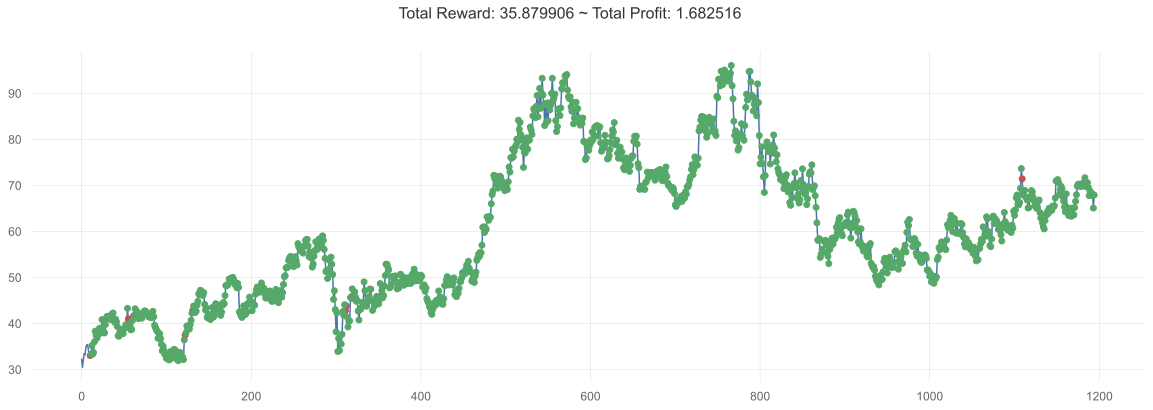

In [82]:
# Load optimized model
model = DQN.load("saved_models/20000_200_4_4_net_arch50,100_0.2_0.8_0.0001")
# Reset environment to its initial state
observation, info = env.reset(seed=2023)

# Initiate dictionary to store action counts
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

# Loop to apply the trained model on the environment
while True:
    action, _states = model.predict(observation, deterministic = True)
    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        print("info:", info)
        print("action_stats:", action_stats)
        break

env.close()

# Plot results
plt.figure(figsize=(20, 6))
env.unwrapped.render_all()
plt.show()

## 8. Compare and interpret the results

### 8.1. Compare between non-optimized and optimized EMA strategy

In [83]:
# Normal EMA
ema_norm = ema_strat['strategy'].tz_localize(None)
# Optimized EMA
ema_optz = ema_strategy(mu_data, 88, 292)
ema_optz = ema_optz['strategy'].tz_localize(None)

qs.reports.metrics(ema_optz, ema_norm)

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2019-01-03   2019-01-03
End Period          2023-09-29   2023-09-29
Risk-Free Rate      0.0%         0.0%
Time in Market      61.0%        78.0%

Cumulative Return   -14.63%      53.6%
CAGR﹪              -2.28%       6.45%

Sharpe              0.07         0.43
Prob. Sharpe Ratio  56.32%       82.26%
Sortino             0.1          0.61
Sortino/√2          0.07         0.43
Omega               1.09         1.09

Max Drawdown        -51.57%      -46.06%
Longest DD Days     1318         942

Gain/Pain Ratio     0.02         0.09
Gain/Pain (1M)      0.08         0.58

Payoff Ratio        0.93         0.93
Profit Factor       1.02         1.09
Common Sense Ratio  1.01         1.12
CPC Index           0.48         0.54
Tail Ratio          0.99         1.03
Outlier Win Ratio   7.37         4.94
Outlier Loss Ratio  2.8          2.67

MTD                 -3.04%       -3.04%
3M            

### 8.2. Compare between optimized EMA strategy and optimized RL strategy

In [ ]:
# Calculate metrics and visualize plots
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=mu_data.index[0:1184])
rl_returns = net_worth.pct_change().iloc[1:]

rl_returns = rl_returns.tz_localize(None)

qs.reports.full(rl_returns, ema_optz)